In [428]:
using Distributed

In [351]:
using Statistics

using ProgressMeter

using DifferentialEquations
using Printf
using Plots
gr(fmt="svg")

# include("../src/HHModel.jl")

Plots.GRBackend()

In [614]:
# Persistent Sodium Plus Potassium Model

# stimulus setup
function dual_pulse(t, param)
    _time = t - param.start
    if 0 < _time < param.pulse_length
        param.pulse_one + param.baseline
    elseif param.pulse_length + param.pulse_interval < _time < 2*param.pulse_length + param.pulse_interval
        param.pulse_two + param.baseline
    else
        param.baseline
    end
end

_pulse_peak = (tspan, trace, param) -> begin
    _roi_1 = (param.start .< tspan) .& (tspan .< param.start+param.pulse_length+param.pulse_interval)
    _roi_1_offset = length(_tspan[_tspan .<= param.start])
    (_val_1, _pos_1) = findmax(trace[_roi_1])
    
    _roi_2 = (param.start+param.pulse_length+param.pulse_interval .< tspan) .& (tspan .< param.start+2*(param.pulse_length+param.pulse_interval))
    _roi_2_offset = length(_tspan[_tspan .<= param.start+param.pulse_length+param.pulse_interval])
    (_val_2, _pos_2) = findmax(trace[_roi_2])
    
    [tspan[_pos_1+_roi_1_offset], tspan[_pos_2+_roi_2_offset]], [_val_1, _val_2]
end

# Biophysics setup

Na_m = HHModel.Kinetics(1, -20.0, 15.0, _type=:instantaneous)
Na = HHModel.SimpleIonChannel("Persistent Sodium", :sodium, 20.0,
    Na_m, HHModel.Kinetics());

# K_m = HHModel.Kinetics(1, -25.0, 5.0)
K_m = HHModel.Kinetics(1, -40.0, 5.0)
K = HHModel.SimpleIonChannel("ltk", :potassium, 10.0,
    K_m, HHModel.Kinetics());

il = HHModel.leakage(8);
_model = [Na, K, il];

# # biophysical model setup ==> usu. for maximum conductance
# ikh = HHModel.high_voltage_gated_potassium(2.8, phi=0.85)
# ikl = HHModel.low_voltage_gated_potassium(0.1, subtype=:kv1)
# # ik = HHModel.hh_potassium(10.0)
# ina = HHModel.hh_sodium(13.0)
# ih = HHModel.ihcurrent(0.1, level=7)
# il = HHModel.leakage(0.01)

# _my_Rs = 1.0
# _model = [ikh, ikl, ina, ih, il]




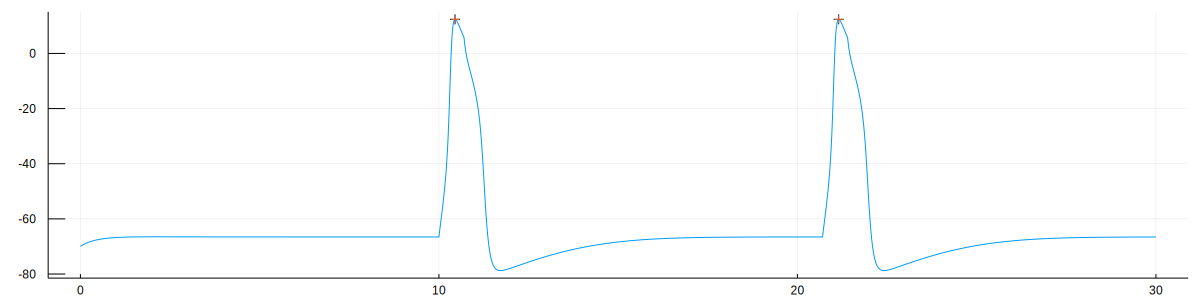

In [615]:
# setup initial values and run the simulation
u0 = HHModel.setup_init(_model, -70.0)
tspan = (0.0, 30.0)
_interval_set = 10.0
_reversal_potential = (sodium=60.0, potassium=-90.0, leak=-80.0) # ikh
# _reversal_potential = (sodium=82.0, potassium=-81.0, ih=-46.0, leak=-65.0, syn=3.0)
# _reversal_potential = (sodium=60.0, potassium=-90.0, leak=-78.0) # ikl

_stimulus_parameter = (start=10, pulse_length=0.7, pulse_interval=_interval_set, pulse_one=110, pulse_two=110, baseline=0.0)

# create model cell simulation
_model_sim = HHModel.CurrentClampSimulation(_model, dual_pulse, C=1.0)


_p = (E=_reversal_potential, stim=_stimulus_parameter)

prob = ODEProblem(_model_sim, u0, tspan, _p)
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8);
_tspan = 0:0.01:30
_trace = hcat(sol(_tspan)...)[1, :];
# simple preview
# plot(sol, vars=(1))


a = plot(_tspan, _trace, legend=nothing, size=(1200, 300))
scatter!(_pulse_peak(_tspan, _trace, _stimulus_parameter)..., markershape=:cross)

In [616]:
savefig("facilitation_trace_vhalf_40.svg")

In [437]:
prob.p

(E = (sodium = 82.0, potassium = -81.0, ih = -46.0, leak = -65.0, syn = 3.0), stim = (start = 500, pulse_length = 0.7, pulse_interval = 86.5, pulse_one = 40, pulse_two = 40, baseline = 0.0))

In [442]:
u0 = HHModel.setup_init(_model, -63.0)
_sweep = 10.0:(0.5):150
_stimulus_parameter = (start=500, pulse_length=0.7, pulse_interval=_sweep[1], pulse_one=40, pulse_two=40, baseline=0.0)
_p = (E=_reversal_potential, stim=_stimulus_parameter)
prob = ODEProblem(_model_sim, u0, tspan, _p)

_prob_func = (prob,i,repeat) -> begin
    _stimulus_parameter = (start=500, pulse_length=0.7, pulse_interval=_sweep[i], pulse_one=40, pulse_two=40, baseline=0.0)
    _p = (E=_reversal_potential, stim=_stimulus_parameter)
    ODEProblem(prob.f, u0, tspan, _p)
end

_prob = EnsembleProblem(prob, 
    prob_func=_prob_func,
    output_func=(sol, i)->(sol, false),
    reduction = (u,data,I)->(append!(u,data),false),
    u_init = u0
)
sim = solve(_prob, Tsit5(),EnsembleThreads(), trajectories=length(_sweep), reltol=1e-8, abstol=1e-8);

MethodError: MethodError: Cannot `convert` an object of type ODESolution{Float64,2,Array{Array{Float64,1},1},Nothing,Nothing,Array{Float64,1},Array{Array{Array{Float64,1},1},1},ODEProblem{Array{Float64,1},Tuple{Float64,Float64},true,NamedTuple{(:E, :stim),Tuple{NamedTuple{(:sodium, :potassium, :ih, :leak, :syn),NTuple{5,Float64}},NamedTuple{(:start, :pulse_length, :pulse_interval, :pulse_one, :pulse_two, :baseline),Tuple{Int64,Float64,Float64,Int64,Int64,Float64}}}},ODEFunction{true,getfield(Main.HHModel, Symbol("##52#54")){Float64,Array{Main.HHModel.AbstractIonChannel,1},typeof(dual_pulse),Int64},LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},DiffEqBase.StandardODEProblem},Tsit5,OrdinaryDiffEq.InterpolationData{ODEFunction{true,getfield(Main.HHModel, Symbol("##52#54")){Float64,Array{Main.HHModel.AbstractIonChannel,1},typeof(dual_pulse),Int64},LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},Array{Array{Float64,1},1},Array{Float64,1},Array{Array{Array{Float64,1},1},1},OrdinaryDiffEq.Tsit5Cache{Array{Float64,1},Array{Float64,1},Array{Float64,1},OrdinaryDiffEq.Tsit5ConstantCache{Float64,Float64}}},DiffEqBase.DEStats} to an object of type Float64
Closest candidates are:
  convert(::Type{T<:Number}, !Matched::T<:Number) where T<:Number at number.jl:6
  convert(::Type{T<:Number}, !Matched::Number) where T<:Number at number.jl:7
  convert(::Type{T<:Number}, !Matched::Base.TwicePrecision) where T<:Number at twiceprecision.jl:250
  ...

In [583]:
_sweep = 0.5:(0.1):10.0
_n_repeat=3
_dt = Array{Float64}(undef, length(_sweep), _n_repeat)
_dpeak = Array{Float64}(undef, length(_sweep), _n_repeat)
_interval = Array{Float64}(undef, length(_sweep), _n_repeat)
_tspan = 0:0.01:30
pbar = Progress(length(_sweep))
for (_idx, _IEI) = enumerate(_sweep)
    for _ridx = 1:_n_repeat
        _stimulus_parameter = (start=10, pulse_length=0.7, pulse_interval=_IEI, pulse_one=40, pulse_two=40, baseline=0.0)
        _p = (E=_reversal_potential, stim=_stimulus_parameter)
        prob = ODEProblem(_model_sim, u0, tspan, _p)
        sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8);
        _trace = hcat(sol(_tspan)...)[1, :];
        _t, _peak = _pulse_peak(_tspan, _trace, _stimulus_parameter)
        
        _v0 = sol(9.0)[1]
        _dpeak[_idx, _ridx] = (_peak[2]-_v0)/(_peak[1]-_v0)
    end
    next!(pbar)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:19


In [584]:
_dpeak[_dpeak .>= 1.1] .= NaN;
_dpeak[_dpeak .<= -1.0] .= NaN;

for _row = 1:size(_dpeak, 1)
    _tmp = _dpeak[_row, :]
    _tmp[isnan.(_tmp)] .= mean(_tmp[.!(isnan.(_tmp))])
    _dpeak[_row, :] = _tmp
end

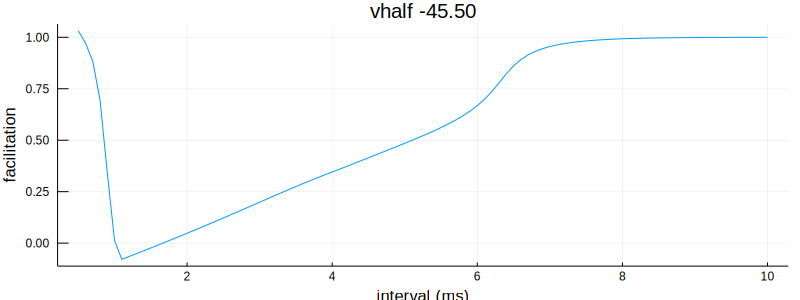

In [586]:
_dpeak_avg = mean(_dpeak, dims=2);

plot(_sweep, _dpeak_avg, legend=nothing, 
    title="vhalf -45.50", xlabel="interval (ms)", ylabel="facilitation")
# savefig("facilitation_vhalf_47.svg")

In [587]:
_dpeak_results_vhalfs["-45.5"] = _dpeak_avg;
_dpeak_results_vhalfs

Dict{Any,Any} with 11 entries:
  "-45"   => [0.957465; 0.891753; … ; 0.999959; 0.999966]
  "-70"   => [0.824795; 0.850366; … ; 1.0; 1.0]
  "-50"   => [0.492239; 0.522032; … ; 1.0; 0.999999]
  "-46"   => [0.174732; 0.0298994; … ; 0.999992; 1.00001]
  "-49"   => [0.412999; 0.441052; … ; 1.0; 1.0]
  "-65"   => [0.800176; 0.827548; … ; 1.0; 1.0]
  "-45.5" => [1.03129; 0.971862; … ; 0.999807; 0.999844]
  "-55"   => [0.718207; 0.748909; … ; 1.0; 1.0]
  "-60"   => [0.773239; 0.800657; … ; 1.0; 1.0]
  "-40"   => [0.832071; 0.765351; … ; 0.999978; 0.999981]
  "-47"   => [0.193798; 0.21817; … ; 0.999998; 1.0]

In [489]:
_dpeak_results["ikl_9"] = _dpeak_avg;
_dpeak_results

Dict{Any,Any} with 3 entries:
  "ikl_9"  => [0.70361; 0.734609; … ; 1.0; 1.0]
  "ikl_10" => [0.718207; 0.748909; … ; 1.0; 1.0]
  "ikl_11" => [0.728841; 0.759065; … ; 1.0; 0.666667]

In [591]:
plot()
for (_key, _val) in _dpeak_results
    plot!(_sweep, _val, label=_key)
end
plot!(title="ikl conductance", xlabel="interval (ms)", ylabel="facilitation")
savefig("facilitation_ikl.svg")

---

In [ ]:
_trace_1_tspan = _stimulus_parameter.start:0.01:(_stimulus_parameter.start+1.5)
_trace_2_start = (_stimulus_parameter.start + _stimulus_parameter.pulse_length + _stimulus_parameter.pulse_interval)
_trace_2_tspan = _trace_2_start:0.01:(_trace_2_start+1.5)

_trace_1 = hcat(sol(_trace_1_tspan)...)[1,:];
_max_1 = maximum(_trace_1)

_trace_2 = hcat(sol(_trace_2_tspan)...)[1,:];
_max_2 = maximum(_trace_2)

_diff = _max_2 - _max_1

In [ ]:
_n = 5
_interval_range = 1.0:0.1:2.0
_pulse_range = 100:10:200
_result = zeros(length(_interval_range), length(_pulse_strength), _n)
_progress_bar = Progress(length(_pulse_strength) * length(_interval_range) * _n)

for _n_idx = 1:_n
    for (_interval_idx, _interval_step) in enumerate(_interval_range)
        for (_pulse_idx, _pulse_step) in enumerate(_pulse_range)

            _stimulus_parameter = (start=10, pulse_length=0.5, pulse_interval=_interval_step, pulse_one=110, pulse_two=_pulse_step, baseline=0.0)

            _p = (E=_reversal_potential, stim=_stimulus_parameter)

            prob = ODEProblem(_model_sim, u0, tspan, _p)
            sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8);

            _trace_1_tspan = _stimulus_parameter.start:0.01:(_stimulus_parameter.start+1.5)
            _trace_2_start = (_stimulus_parameter.start + _stimulus_parameter.pulse_length + _stimulus_parameter.pulse_interval)
            _trace_2_tspan = _trace_2_start:0.01:(_trace_2_start+1.5)

            _trace_1 = hcat(sol(_trace_1_tspan)...)[1,:];
            _max_1 = maximum(_trace_1)

            _trace_2 = hcat(sol(_trace_2_tspan)...)[1,:];
            _max_2 = maximum(_trace_2)

            _diff = _max_2 - _max_1
            _result[_interval_idx, _pulse_idx, _n_idx] = _diff > 25 ? NaN : _diff
            next!(_progress_bar)
        end
    end
end


_correct_result = zeros(size(_result)[1:2])
for _i_idx = 1:size(_result, 1)
    for _j_idx = 1:size(_result, 2)
        _a = _result[_i_idx, _j_idx, :]
        _a = _a[not.(isnan.(_a))]
        _avg = mean(_a)
        _std = std(_a)
        _a = _std < 3 ? _a : _a[(_avg - _std .< _a) .& (_a .< _avg + _std)]
        _correct_result[_i_idx, _j_idx] = mean(_a)
    end
end

heatmap(_pulse_range ./ 110, _interval_range, _correct_result, #fill=true,
    xlabel="relative pulse strength", ylabel="pulse interval (ms)", colorbar_title="spike strength difference (mV)",
    clim=(-70, 0)
)

In [ ]:
_correct_result[9, 1] = (_correct_result[8, 1] + _correct_result[10, 1]) / 2
plot(_correct_result[:, 1])

In [ ]:
heatmap(_pulse_range ./ 110, _interval_range, _correct_result, #fill=true,
    xlabel="relative pulse strength", ylabel="pulse interval (ms)", colorbar_title="spike strength difference (mV)",
    clim=(-70, 0)
)
# savefig("ltk_10.svg")

In [ ]:
# animation
_n = 5
_interval_range = 1.0:0.1:2.0
_pulse_range = 100:10:200
_g_ltk_range = 8:0.05:11
_progress_bar = Progress(length(_g_ltk_range) * length(_pulse_strength) * length(_interval_range) * _n)

anim = @animate for _g_ltk = _g_ltk_range
    K.g = _g_ltk
    _result = zeros(length(_interval_range), length(_pulse_strength), _n)

    for _n_idx = 1:_n
        for (_interval_idx, _interval_step) in enumerate(_interval_range)
            for (_pulse_idx, _pulse_step) in enumerate(_pulse_range)

                _stimulus_parameter = (start=10, pulse_length=0.5, pulse_interval=_interval_step, pulse_one=110, pulse_two=_pulse_step, baseline=0.0)

                _p = (E=_reversal_potential, stim=_stimulus_parameter)

                prob = ODEProblem(_model_sim, u0, tspan, _p)
                sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8);

                _trace_1_tspan = _stimulus_parameter.start:0.01:(_stimulus_parameter.start+1.5)
                _trace_2_start = (_stimulus_parameter.start + _stimulus_parameter.pulse_length + _stimulus_parameter.pulse_interval)
                _trace_2_tspan = _trace_2_start:0.01:(_trace_2_start+1.5)

                _trace_1 = hcat(sol(_trace_1_tspan)...)[1,:];
                _max_1 = maximum(_trace_1)

                _trace_2 = hcat(sol(_trace_2_tspan)...)[1,:];
                _max_2 = maximum(_trace_2)

                _diff = _max_2 - _max_1
                _result[_interval_idx, _pulse_idx, _n_idx] = _diff > 25 ? NaN : _diff
                next!(_progress_bar)
            end
        end
    end


    _correct_result = zeros(size(_result)[1:2])
    for _i_idx = 1:size(_result, 1)
        for _j_idx = 1:size(_result, 2)
            _a = _result[_i_idx, _j_idx, :]
            _a = _a[not.(isnan.(_a))]
            _avg = mean(_a)
            _std = std(_a)
            _a = _std < 3 ? _a : _a[(_avg - _std .< _a) .& (_a .< _avg + _std)]
            _correct_result[_i_idx, _j_idx] = mean(_a)
        end
    end

    heatmap(_pulse_range ./ 110, _interval_range, _correct_result, #fill=true,
        xlabel="relative pulse strength", ylabel="pulse interval (ms)", colorbar_title="spike strength difference (mV)",
        clim=(-70, 0), title=@sprintf("g_ltk = %.2f", _g_ltk)
    ) 
end

In [ ]:
gif(anim, "test.gif", fps=12)